# Preliminary steps and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/MLinA_project/

/content/drive/MyDrive/MLinA_project


In [3]:
import torch
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import re
import numpy as np
from tqdm.auto import tqdm
from torch import cuda

# Utils

## Define a function to extract latent embeddings given a model

In [4]:
# extract latent vectors for the entire dataset
def extract_latent_vectors(model, dataloader, model_name):
    steps = len(dataloader)
    progress_bar = tqdm(total = steps)

    latent_vectors = []
    labels = []
    model.eval()
    with torch.no_grad():
        count = 0
        for data,target,_,_ in dataloader:
            count += 1
            data = data.to(device)
            target = target.to(device)
            mu, logvar = model.encode(data)
            latent_vector = model.reparameterize(mu, logvar)
            latent_vectors.append(latent_vector.cpu().numpy())
            labels.append(target.cpu().numpy())

            if count == 100:#
                count = 0#
                np.save(f'features_{model_name}.npy', np.concatenate(latent_vectors))
                np.save(f'labels_{model_name}.npy', np.concatenate(labels))

            progress_bar.update(1)
    return np.concatenate(latent_vectors), np.concatenate(labels)

## Function to plot vae losses

In [5]:
def plot_losses(total_loss, mse, kld, beta):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    axs[0].plot(total_loss, label='Total Loss', color='blue')
    axs[0].set_title('Total Loss')
    axs[0].set_xlabel('steps')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(mse, label='MSE', color='green')
    axs[1].set_title('MSE')
    axs[1].set_xlabel('steps')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    axs[2].plot(kld, label='KLD', color='red')
    axs[2].set_title('kld')
    axs[2].set_xlabel('steps')
    axs[2].set_ylabel('Loss')
    axs[2].legend()

    plt.tight_layout()
    plt.savefig(f'losses_vae_beta={beta}.png')
    # plt.show()

## Function to visualize original and reconstructed images

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def visualize_reconstructions(model, samples, num_images=6):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        samples = samples.to(device)

        # Get the reconstructed images
        recon_batch, _, _ = model(samples)

        # Move tensors to CPU and detach
        samples = samples.cpu()
        recon_batch = recon_batch.cpu()

        # Create a grid of original and reconstructed images
        original_grid = make_grid(samples[:num_images], nrow=num_images, normalize=True, pad_value=1)
        reconstructed_grid = make_grid(recon_batch[:num_images], nrow=num_images, normalize=True, pad_value=1)

        # Plot the images
        fig, axes = plt.subplots(2, 1, figsize=(num_images * 2, 4))
        axes[0].imshow(original_grid.permute(1, 2, 0))
        axes[0].set_title('Original Images')
        axes[0].axis('off')

        axes[1].imshow(reconstructed_grid.permute(1, 2, 0))
        axes[1].set_title('Reconstructed Images')
        axes[1].axis('off')

        plt.show()

# Dataset creation

In [7]:
import dataset_patches
from dataset_patches import patchesDataset

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((256,256))
            ])

dataset = patchesDataset(root_dir='patches', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
# for images, labels, patient_ids, coordinates in dataloader:
#     print(images[0].size())  # Tensor shape: (batch_size, channels, height, width)
#     print(labels)  # Labels: 0 (no cancer) or 1 (cancer)
#     print(patient_ids)  # Patient IDs: 1 to 24
#     print(coordinates)  # Coordinates: (x, y) tuples
#     break

# Basic Variational Autoencoder

## Network definition

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256*32*32, latent_dim)
        self.fc_logvar = nn.Linear(256*32*32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256*32*32),
            nn.ReLU(),
            nn.Unflatten(1, (256, 32, 32)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

## Training

In [ ]:
# Model, optimizer, and training parameters

current_epochs = 0

model = VAE(latent_dim=100).to(device)
try:
  model.load_state_dict(torch.load(f'vae_model_{current_epochs}.pth'))
  print('Model loaded correctly!')
except:
    ...
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, _, _, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+current_epochs+1}/{num_epochs}")):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+current_epochs+1}/{num_epochs}, Loss: {total_loss / len(dataloader.dataset):.4f}")
    if (epoch+1)%2==0 and epoch>0:
        torch.save(model.state_dict(), f'vae_{epoch+current_epochs+1}.pth')

# Save the trained model
torch.save(model.state_dict(), f'vae_100.pth')

## Extract and save the features using the basic VAE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(100).to(device)
model.load_state_dict(torch.load('vae_model_60.pth'))

In [ ]:
latent_vectors, labels = extract_latent_vectors(model, dataloader, 'vae')

In [ ]:
print(latent_vectors.shape)
print(labels.shape)

In [ ]:
np.save('latent_vectors_vae_final.npy', latent_vectors)
np.save('labels_vae_final.npy', labels)
import pickle

with open('extracted_features.pkl', 'wb') as f:
    pickle.dump((latent_vectors, labels), f)


## Train an SVM model using the basic VAE features


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

latent_vectors = np.load('extracted_features/old/vae_features.npy')
labels = np.load('extracted_features/old/vae_labels.npy')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(latent_vectors, labels, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7189908899789769
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73      1475
           1       0.71      0.71      0.71      1379

    accuracy                           0.72      2854
   macro avg       0.72      0.72      0.72      2854
weighted avg       0.72      0.72      0.72      2854



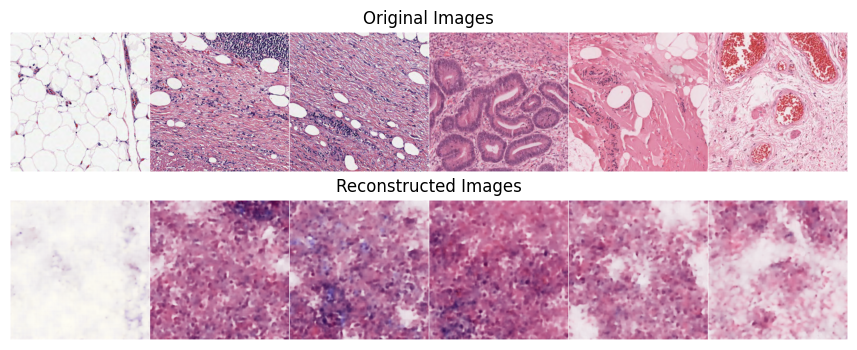

In [ ]:
# show some reconstructed images
from torch.utils.data._utils.collate import default_collate


model = VAE(100)
model.load_state_dict(torch.load('trained_models/old/basic_vae_60.pth'))

selected_samples = [dataset[i][0] for i in [100,300,400,600,1000,1300]]
samples = default_collate(selected_samples)

visualize_reconstructions(model, samples)

# ResNet based VAE
Something similar was used in [CLINICALLY RELEVANT LATENT SPACE EMBEDDING OF CANCER HISTOPATHOLOGY SLIDES THROUGH VARIATIONAL AUTOENCODER BASED IMAGE COMPRESSION](https://arxiv.org/pdf/2303.13332).Its code can be found in [this](https://github.com/jacobluber/uta_cancer_search) github folder but doesn't work anymore because of torch lightning...
The specific vae we use was found in [this folder](https://github.com/julianstastny/VAE-ResNet18-PyTorch/blob/master/model.py).
With respect to the original vae some changes were applied:
1. first of all al the dimensions had to be adjusted to our data
2. changed num_blocks from [2,2,2,2] to [1,1,1,1] to reduce the complexity of the network and go from 14.7M parameters to 13.5M
3. added max pooling layers before linear layers to reduce the number of parameters from 13.5M to 5.7M

In [9]:
import torch
from torch import nn
import torch.nn.functional as F

class ResizeConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, num_blocks=[1,1,1,1], z_dim=128, nc=3):
        super().__init__()
        self.in_planes = 32
        self.conv1 = nn.Conv2d(nc, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.z_dim = z_dim
        self.layer1 = self._make_layer(BasicBlockEnc, 16, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(BasicBlockEnc, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 128, num_blocks[3], stride=2)
        self.maxpool = nn.MaxPool2d(2,2)  # changed from 4,4 to 2,2 to go from input size 512*512 to 256*256
        self.linear = nn.Linear(128 * 4 * 4, 2 * z_dim)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.in_planes, planes, stride))
            else:
                layers.append(block(planes, planes, 1))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class BasicBlockDec(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv1 = ResizeConv2d(in_planes, out_planes, kernel_size=3, scale_factor=stride)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, out_planes, kernel_size=1, scale_factor=stride),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        # Adjust shortcut connection to match spatial dimensions
        shortcut_x = self.shortcut(x)
        if shortcut_x.size(2) != out.size(2) or shortcut_x.size(3) != out.size(3):
            shortcut_x = F.interpolate(shortcut_x, size=(out.size(2), out.size(3)), mode='nearest')
        out += shortcut_x
        out = torch.relu(out)
        return out

class ResNet18Dec(nn.Module):
    def __init__(self, num_blocks=[1,1,1,1], z_dim=128, nc=3):
        super().__init__()
        self.in_planes = z_dim
        self.linear = nn.Linear(z_dim, 128 * 16 * 16)
        self.layer4 = self._make_layer(BasicBlockDec, 128, num_blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 64, num_blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 32, num_blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 16, num_blocks[0], stride=2)
        self.conv1 = ResizeConv2d(16, nc, kernel_size=3, scale_factor=1)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.in_planes, planes, stride))
            else:
                layers.append(block(planes, planes, 1))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 128, 16, 16)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        return x

class ResVAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar

    def reparameterize(self, mean, logvar):
        if self.train:
            std = torch.exp(logvar / 2)
            epsilon = torch.randn_like(std)
            return epsilon * std + mean
        else:
            return mean

    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x, reduction='mean')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE, KLD

In [ ]:
from torchsummary import summary
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
model = ResVAE(128).to(device)
summary(model, (3,256,256))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3           [-1, 16, 64, 64]           4,608
       BatchNorm2d-4           [-1, 16, 64, 64]              32
            Conv2d-5           [-1, 16, 64, 64]           2,304
       BatchNorm2d-6           [-1, 16, 64, 64]              32
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
     BasicBlockEnc-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 32, 32, 32]           4,608
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
           Conv2d-14           [-1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


## Training

In [ ]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Hyperparameters
z_dim = 128
num_epochs = 45
learning_rate = 1e-5
beta = 1e-05
checkpoint_path = f'ResVAE_MSE_beta={beta}_lr={learning_rate}_checkpoint.pth'
# checkpoint_path = 'ResVAE_MSE_30_beta=1e-05_lr=1e-05.pth'

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResVAE(z_dim=z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Load checkpoint if available
start_epoch = 0
total_loss = 0

# define a weighted funtion for beta
def weight_beta(num_epochs, beta):
    if beta==1:
        x = np.linspace(-6, 6, num_epochs)
        weights = (1 / (1 + np.exp(-x)))*0.05
    else:
        weights = np.ones(num_epochs)
    return weights

try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    total_loss = checkpoint.get('loss', 0)
    print('Model loaded correctly from checkpoint!')
    print(f'Starting from epoch {start_epoch}')
except FileNotFoundError:
    print('No checkpoint found, starting from scratch.')

progress_bar = tqdm(range(len(dataloader)*(num_epochs-start_epoch)))
loss_history = []
mse_history = []
kld_history = []

# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0
    for data, _, _, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        MSE, KLD = model.loss_function(recon_batch, data, mu, logvar)
        loss = MSE + beta*KLD
        loss_history.append(loss.item())
        kld_history.append(KLD.item())
        mse_history.append(MSE.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.update(1)

    # Save checkpoint every epoch
    if (epoch + 1) % 1 == 0:
        avg_loss = epoch_loss / len(dataloader.dataset)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'ResVAE_MSE_beta={beta}_lr={learning_rate}_checkpoint.pth')


        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        plot_losses(loss_history, mse_history, kld_history, beta)

# Close the tqdm progress bar
progress_bar.close()

# Save the final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, f'ResVAE_MSE_{num_epochs}_beta={beta}_lr={learning_rate}.pth')

## Checking the reconstructed images

In [19]:
data_sample = [np.array(dataset[100][0].permute(1, 2, 0)),
               np.array(dataset[300][0].permute(1, 2, 0)),
               np.array(dataset[400][0].permute(1, 2, 0)),
               np.array(dataset[600][0].permute(1, 2, 0)),
               np.array(dataset[1000][0].permute(1, 2, 0)),
               np.array(dataset[1300][0].permute(1, 2, 0))]

In [20]:
from torch.utils.data._utils.collate import default_collate
selected_samples = [dataset[i][0] for i in [100,300,400,600,1000,1300]]
samples = default_collate(selected_samples)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResVAE(128).to(device)
loading = torch.load(f'ResVAE_MSE_{num_epochs}_beta={beta}_lr={learning_rate}.pth', torch.device('cpu'))
model.load_state_dict(loading['model_state_dict'])

<All keys matched successfully>

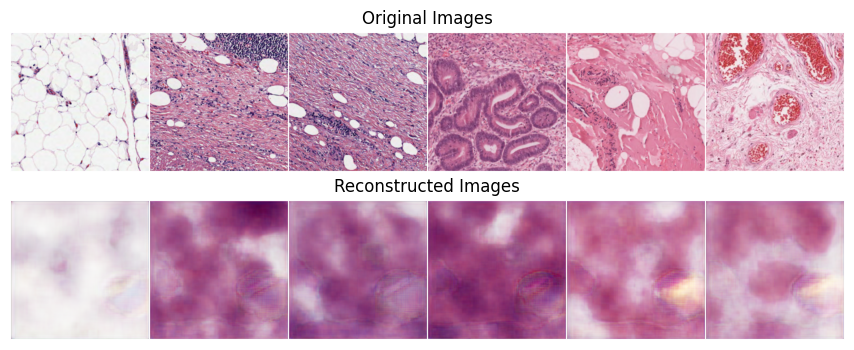

In [21]:
visualize_reconstructions(model, samples)

## Extract and save the features using ResVAE

In [ ]:
num_epochs = 45
learning_rate = 1e-5
beta = 1e-05

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResVAE(128).to(device)
model.load_state_dict(torch.load(f'ResVAE_MSE_{num_epochs}_beta={beta}_lr={learning_rate}.pth')['model_state_dict'])

<All keys matched successfully>

In [ ]:
from torch.utils.data import Subset
import random

# Get a subset of 1000 random indices
# random_indices = random.sample(range(14269), 1000)

# # Create a subset of the dataset
# subset = Subset(dataset, random_indices)
# dataloader = DataLoader(subset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [14]:
latent_vectors, labels = extract_latent_vectors(model, dataloader, f'ResVAE_MSE_{num_epochs}_beta={beta}_lr={learning_rate}.pth')

100%|██████████| 892/892 [05:29<00:00,  2.71it/s]


## Train an SVM model using ResVAE features


In [ ]:
# latent_vectors = np.load('extracted_features/features_ResVAE_MSE_35_beta=1e-05_lr=1e-05.npy')
# labels = np.load('extracted_features/labels_ResVAE_MSE_35_beta=1e-05_lr=1e-05.npy')

In [15]:
latent_vectors.shape

(14269, 128)

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(latent_vectors, labels, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.752978276103714
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.76      1475
           1       0.75      0.74      0.74      1379

    accuracy                           0.75      2854
   macro avg       0.75      0.75      0.75      2854
weighted avg       0.75      0.75      0.75      2854

